In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os
from utils import ImageNode

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
DISTANCE_THRESHOLD_PERCENTILE = 90
RANSAC_THRESHOLD = 5
SCALE_FACTOR = 0.5

# 1. Load images

In [3]:
data_tag = 'isr_wall'
data_path = Path(os.getcwd()) / data_tag

kps_fpaths = sorted((data_path / 'input').glob('kp*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

imgs_fpaths = sorted((data_path / 'input').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

ref_kps_fpath = data_path / 'reference' / 'kp_ref.mat'
ref_img_fpath = data_path / 'reference' / 'img_ref.jpg'

In [4]:
# Load keypoints and descriptors supplied

keypoints = [spio.loadmat(fpath)['kp'] for fpath in kps_fpaths]
descriptors = [spio.loadmat(fpath)['desc'] for fpath in kps_fpaths]

ref_keypoints = spio.loadmat(ref_kps_fpath)['kp']
ref_descriptors = spio.loadmat(ref_kps_fpath)['desc']

images = [np.array(Image.open(fpath)) for fpath in imgs_fpaths]
ref_img = np.array(Image.open(ref_img_fpath))

In [5]:
# # Optional: recalculate SIFT with descriptors of size 128

# sift = cv2.SIFT_create()

# # Extract keypoints and descriptors for each image
# keypoints = []
# descriptors = []

# for img in tqdm(images):
#     kps, descs = sift.detectAndCompute(img, None)
#     keypoints_array = np.array([kp.pt for kp in kps], dtype=np.float32)
#     descs = descs.astype(np.float32)
#     keypoints.append(keypoints_array)
#     descriptors.append(descs)

# # Extract keypoints and descriptors for the reference image
# kps, descs = sift.detectAndCompute(ref_img, None)
# ref_descriptors = descs.astype(np.float32)
# ref_keypoints = np.array([kp.pt for kp in kps], dtype=np.float32)


In [6]:
from utils import resize_keypoint_and_image


for i in range(len(keypoints)):
    keypoints[i], images[i] = resize_keypoint_and_image(keypoints[i], images[i], SCALE_FACTOR)
    
ref_keypoints, ref_img = resize_keypoint_and_image(ref_keypoints, ref_img, SCALE_FACTOR)


In [7]:
image_nodes = [ImageNode(image, kp, desc, idx) for idx, (image, kp, desc) in enumerate(zip(images, keypoints, descriptors))]
image_node_ref = ImageNode(ref_img, ref_keypoints, ref_descriptors, idx=-1)

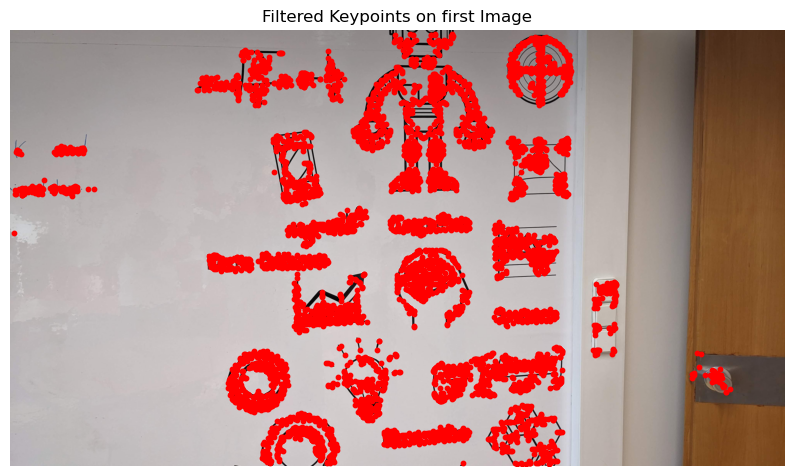

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image_nodes[0].image, cmap='gray')
plt.scatter(image_nodes[0].keypoints[:, 0], image_nodes[0].keypoints[:, 1], c='r', s=10)
plt.title("Filtered Keypoints on first Image")
plt.axis('off')
plt.show()

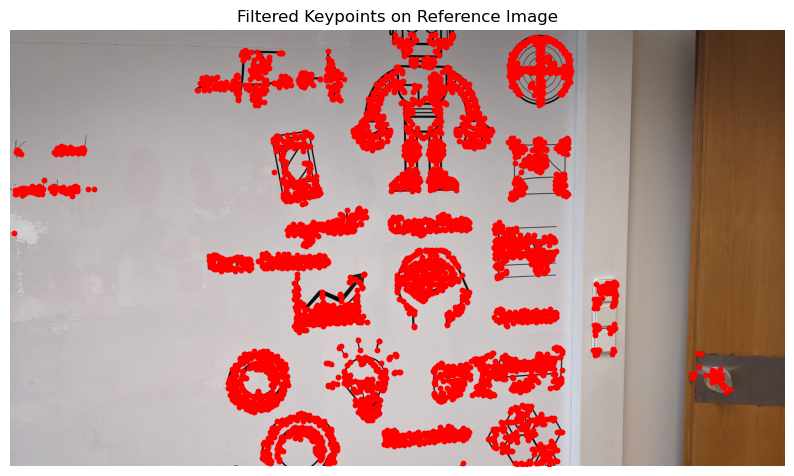

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(ref_img, cmap='gray')
plt.scatter(ref_keypoints[:, 0], ref_keypoints[:, 1], c='r', s=10)
plt.title("Filtered Keypoints on Reference Image")
plt.axis('off')
plt.show()

# 2. Compute thresholds

In [10]:
def compute_homography_ransac(src_pts, dst_pts, ransac_threshold):
    """
    Compute homography using numpy with RANSAC.

    Args:
        src_pts (np.ndarray): Source points (Nx2).
        dst_pts (np.ndarray): Destination points (Nx2).
        ransac_threshold (float): RANSAC inlier threshold.

    Returns:
        H (np.ndarray): Normalized homography matrix.
        inlier_mask (np.ndarray): Boolean array of inliers.
    """
    max_inliers = 0
    best_H = None
    best_inlier_mask = None
    num_points = src_pts.shape[0]
    iterations = 1000

    for _ in range(iterations):
        # Randomly sample 4 points
        indices = np.random.choice(num_points, 4, replace=False)
        sampled_src = src_pts[indices]
        sampled_dst = dst_pts[indices]

        # Solve for H using the sampled points
        A = []
        for (x, y), (x_p, y_p) in zip(sampled_src, sampled_dst):
            A.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p, x_p])
            A.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p, y_p])
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        H = Vt[-1].reshape(3, 3)

        # Normalize the homography matrix (ensure H[2, 2] = 1)
        if H[2, 2] != 0:
            H /= H[2, 2]

        # Compute inliers using optimized norm distance calculation
        src_h = np.hstack([src_pts, np.ones((num_points, 1))])  # Homogeneous coordinates
        dst_proj = src_h @ H.T
        dst_proj /= dst_proj[:, 2:3]  # Normalize to get (x, y)

        # Efficient squared distance calculation with safeguard
        distances = np.sqrt(
            np.maximum(
                0,
                np.sum(dst_pts**2, axis=1) +
                np.sum(dst_proj[:, :2]**2, axis=1) -
                2 * np.sum(dst_pts * dst_proj[:, :2], axis=1)
            )
        )

        # Compute inliers based on the threshold
        inlier_mask = distances < ransac_threshold
        num_inliers = np.sum(inlier_mask)

        # Update the best model
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inlier_mask = inlier_mask

    return best_H, best_inlier_mask


In [11]:
def find_matches_numpy(src_node, dst_node, max_desc_dist=None):
    """
    Find matches between two ImageNode objects using numpy with cross-check.

    Args:
        src_node (ImageNode): Source image node.
        dst_node (ImageNode): Destination image node.
        max_desc_dist (float, optional): Maximum descriptor distance for valid matches.

    Returns:
        src_pts (np.ndarray): Matched keypoints from the source node.
        dst_pts (np.ndarray): Matched keypoints from the destination node.
    """
    # Extract descriptors
    src_descriptors = src_node.descriptors
    dst_descriptors = dst_node.descriptors

    distances = np.sqrt(
        np.maximum(
            0,
            np.sum(src_descriptors[:, None, :] ** 2, axis=2) + 
            np.sum(dst_descriptors[None, :, :] ** 2, axis=2) - 
            2 * np.dot(src_descriptors, dst_descriptors.T)
        )
    )

    # Find the nearest neighbor in both directions
    src_to_dst = np.argmin(distances, axis=1)
    dst_to_src = np.argmin(distances, axis=0)

    # Reciprocal matching (cross-check logic)
    reciprocal_matches = [
        (src_idx, dst_idx)
        for src_idx, dst_idx in enumerate(src_to_dst)
        if dst_to_src[dst_idx] == src_idx
    ]

    # Apply distance threshold if provided
    if max_desc_dist is not None:
        reciprocal_matches = [
            (src_idx, dst_idx)
            for src_idx, dst_idx in reciprocal_matches
            if distances[src_idx, dst_idx] <= max_desc_dist
        ]

    # Extract matched keypoints
    src_pts = np.array([src_node.keypoints[src_idx] for src_idx, _ in reciprocal_matches], dtype=np.float32)
    dst_pts = np.array([dst_node.keypoints[dst_idx] for _, dst_idx in reciprocal_matches], dtype=np.float32)

    return src_pts, dst_pts


In [12]:
def max_descriptor_distance_threshold_numpy(image_nodes, distance_threshold_percentile=100):
    all_thresholds = []

    for i in tqdm(range(len(image_nodes) - 1)):
        src_node = image_nodes[i]
        dst_node = image_nodes[i + 1]

        distances = np.sqrt(
            np.maximum(
                0,
                np.sum(src_node.descriptors[:, None, :] ** 2, axis=2) + 
                np.sum(dst_node.descriptors[None, :, :] ** 2, axis=2) - 
                2 * np.dot(src_node.descriptors, dst_node.descriptors.T)
            )
        )

        # Cross-check logic
        src_to_dst = np.argmin(distances, axis=1)
        dst_to_src = np.argmin(distances, axis=0)
        reciprocal_matches = [
            (src_idx, dst_idx)
            for src_idx, dst_idx in enumerate(src_to_dst)
            if dst_to_src[dst_idx] == src_idx
        ]

        # Collect distances for reciprocal matches
        match_distances = [
            distances[src_idx, dst_idx]
            for src_idx, dst_idx in reciprocal_matches
        ]

        # Calculate the percentile threshold for current image pair
        if match_distances:
            curr_threshold = np.percentile(match_distances, distance_threshold_percentile)
            all_thresholds.append(curr_threshold)

    # Return the maximum threshold across all image pairs
    descriptor_distance_threshold = max(all_thresholds) if all_thresholds else 0.0
    return descriptor_distance_threshold


In [13]:
# def find_matches(src_node, dst_node, max_desc_dist=None):
#     # Note that the index in matches are not aligned with src and dst pts, 
#     # Matches index are aligned to node.keypoints
#     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
#     matches = bf.match(src_node.descriptors, dst_node.descriptors)
    
#     if max_desc_dist != None:
#         matches = [m for m in matches if m.distance <= max_desc_dist]
    
#     src_pts = np.float32([src_node.keypoints[m.queryIdx] for m in matches])
#     dst_pts = np.float32([dst_node.keypoints[m.trainIdx] for m in matches])

#     return src_pts, dst_pts

In [14]:
# def max_descriptor_distance_threshold(image_nodes, distance_threshold_percentile=100):
#     all_thresholds = np.array([])
#     pair_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

#     for i in tqdm(range(len(image_nodes) - 1)):
#         src_desc = image_nodes[i].descriptors
#         dst_desc = image_nodes[i+1].descriptors
#         matches = pair_matcher.match(src_desc, dst_desc)
#         distances = np.array([m.distance for m in matches])
#         curr_threshold = np.percentile(distances, distance_threshold_percentile)
#         all_thresholds = np.append(all_thresholds, curr_threshold)

#     descriptor_distance_threshold = max(all_thresholds)
#     return descriptor_distance_threshold

In [15]:
def compute_min_inliers_threshold(image_nodes, max_desc_dist):
    inliers_per_pair = []

    for i in tqdm(range(len(image_nodes) - 1)):
        src_pts, dst_pts = find_matches_numpy(image_nodes[i], image_nodes[i+1], max_desc_dist)
        # H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESHOLD)
        H, mask = compute_homography_ransac(src_pts, dst_pts, RANSAC_THRESHOLD)
        inliers = np.sum(mask)
        inliers_per_pair.append(inliers)

    min_inliers = min(inliers_per_pair)
    return min_inliers

In [16]:
# %lprun -f max_descriptor_distance_threshold_numpy max_descriptor_distance_threshold_numpy(image_nodes, 90)

In [17]:
max_desc_dist = max_descriptor_distance_threshold_numpy(image_nodes, DISTANCE_THRESHOLD_PERCENTILE)
print('The maximum descriptor distance is:', round(max_desc_dist, 4))

100%|██████████| 8/8 [00:02<00:00,  2.73it/s]

The maximum descriptor distance is: 0.2609


In [18]:
min_inliers_threshold = compute_min_inliers_threshold(image_nodes, max_desc_dist)
print('The minimum number of inliers is:', min_inliers_threshold)

100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

The minimum number of inliers is: 474


# 3. Compute homographies

In [19]:
def find_valid_homography(src_node, dst_node, min_inliers_threshold, max_desc_dist):
    src_pts, dst_pts = find_matches_numpy(src_node, dst_node, max_desc_dist)
    # print(f'Number of matches: {len(src_pts)}')
    # H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESHOLD)
    H, mask = compute_homography_ransac(src_pts, dst_pts, RANSAC_THRESHOLD)
    num_inliers = np.sum(mask)
    is_H_valid = 1 if num_inliers >= min_inliers_threshold else 0
    return H, is_H_valid, num_inliers

In [20]:
def find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold, max_desc_dist):
    valid_homographies = {1: []}

    for i in tqdm(range(len(image_nodes))):
        H, is_H_valid, num_inliers = find_valid_homography(image_nodes[i], image_node_ref, min_inliers_threshold, max_desc_dist)
        
        if is_H_valid:
            image_nodes[i].homography = H
            image_nodes[i].footprint.append('ref')
            valid_homographies[1].append(i)
    return valid_homographies

valid_homographies = find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold, max_desc_dist)

100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


In [21]:
from itertools import chain

def find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold, max_desc_dist):
    level = 1
    while level in valid_homographies:
        best_idxs = valid_homographies[level]
        for node in tqdm(image_nodes):
            if node.idx in list(chain.from_iterable(valid_homographies.values())):
                continue

            nearest_idx = min(best_idxs, key=lambda x: abs(x - node.idx))
            H, is_H_valid, num_inliers = find_valid_homography(node, image_nodes[nearest_idx], min_inliers_threshold, max_desc_dist)

            if is_H_valid:
                node.homography = np.dot(image_nodes[nearest_idx].homography, H)
                valid_homographies.setdefault(level + 1, []).append(node.idx)
                node.footprint.extend(image_nodes[nearest_idx].footprint)
        level += 1

find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold, max_desc_dist)

100%|██████████| 9/9 [00:00<00:00, 260336.11it/s]


# 4. Visualize results

## 4.1 Visualize matches

In [22]:
from plot import draw_matches_points


def show_keypoints_matches(node1, node2, max_desc_dist, num_matches):
    """
    Show the keypoints matches between two image nodes.

    Args:
        node1 (ImageNode): The first image node.
        node2 (ImageNode): The second image node.
    """
    src_pts, dst_pts = find_matches_numpy(node1, node2, max_desc_dist)

    img_matches = draw_matches_points(node1.image, node2.image, src_pts, dst_pts, num_matches)

    # Display the matches
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title(f"Keypoints Matches between Image {node1.idx} and Image {node2.idx}")
    plt.axis('off')
    plt.show()

In [23]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         show_keypoints_matches(node, image_node_ref, max_desc_dist, num_matches=50)
#         counter += 1

## 4.2 Visualize inlier matches

In [24]:
def show_inlier_matches(node1, node2, max_desc_dist=None, ransac_threshold=RANSAC_THRESHOLD, max_points=None):
    """
    Finds matches between two image nodes, computes a homography, and
    visualizes only the inlier matches.

    Args:
        node1 (ImageNode): The first image node (has .image, .keypoints, .descriptors).
        node2 (ImageNode): The second image node.
        max_desc_dist (float, optional): Maximum descriptor distance to keep a match.
        ransac_threshold (float): Threshold for RANSAC homography.
        max_points (int or None): If int, draw up to this many inlier points.
                                  If None, draw all inliers.
    """
    # 1) Find initial descriptor matches + their points
    src_pts, dst_pts = find_matches_numpy(node1, node2, max_desc_dist)

    # 2) Compute homography and get RANSAC's inlier mask
    # H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESHOLD)
    H, mask = compute_homography_ransac(src_pts, dst_pts, RANSAC_THRESHOLD)
    if mask is None:
        print("No homography could be computed.")
        return

    # 3) Filter only inlier points
    inlier_indices = np.where(mask.flatten() == 1)[0]
    inlier_src_pts = src_pts[inlier_indices]
    inlier_dst_pts = dst_pts[inlier_indices]

    # 4) Draw the inlier matches in a side-by-side image
    out_image = draw_matches_points(
        node1.image, node2.image,
        inlier_src_pts, inlier_dst_pts,
        max_points=max_points
    )

    # 5) Show the result
    plt.figure(figsize=(12, 6))
    plt.imshow(out_image)
    plt.title(f"Inlier Matches between Node {node1.idx} and Node {node2.idx}")
    plt.axis("off")
    plt.show()

In [25]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         visualize_inlier_matches(node, image_node_ref, max_desc_dist, RANSAC_THRESHOLD, 50)
#         counter += 1

# 4.3 Visualize path inlier matches

In [26]:
# starting_node = image_nodes[6]
# num_matches = 50
# for idx in range(len(starting_node.footprint)-1):
#     if starting_node.footprint[idx+1] == 'ref':
#         show_inlier_matches(image_nodes[starting_node.footprint[idx]], image_node_ref, max_desc_dist, RANSAC_THRESHOLD, num_matches)
#     if idx + 1 < len(starting_node.footprint) and starting_node.footprint[idx+1] != 'ref':
#         show_inlier_matches(image_nodes[starting_node.footprint[idx]], image_nodes[starting_node.footprint[idx + 1]], max_desc_dist, RANSAC_THRESHOLD, num_matches)
    

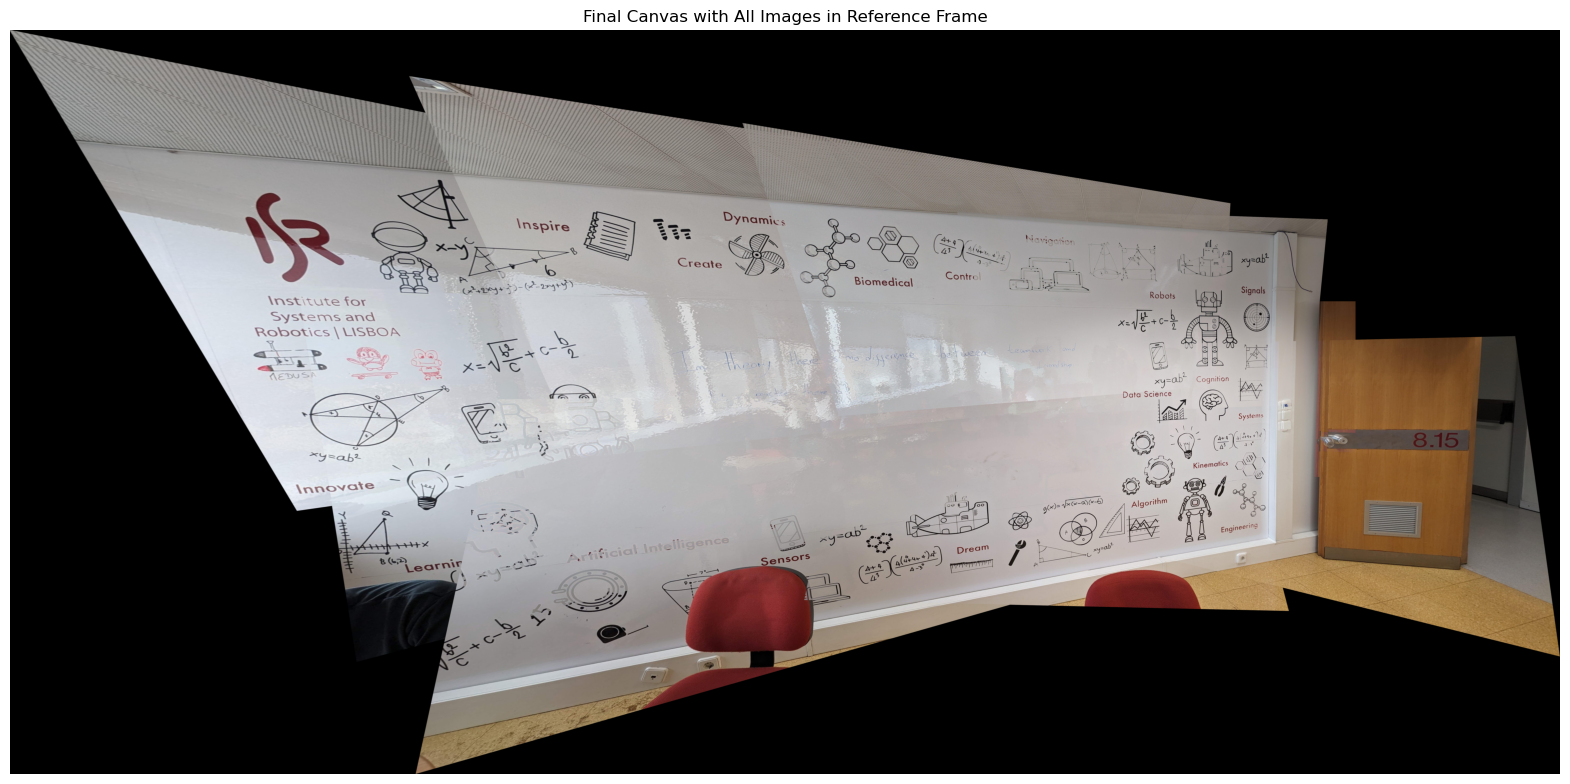

In [27]:
from plot import create_canvas_with_images

# Example usage:
final_canvas = create_canvas_with_images(ref_img, image_nodes)

# Display the final canvas
plt.figure(figsize=(20, 20))
plt.imshow(final_canvas)
plt.title("Final Canvas with All Images in Reference Frame")
plt.axis('off')

# Save the canvas to the current directory
plt.savefig('final_canvas.png', bbox_inches='tight')
plt.show()